### Data Image
Loading a sample image from our dataset with manual object localization and resizing to it's original size. Changing the image to grayscale as carrying out operations on grayscale images is computationally lightweight

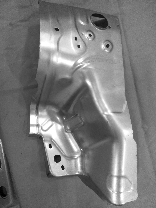

In [1]:
import cv2 as cv #openCV
import numpy as np
import pandas as pd
from PIL import Image #pillow
import matplotlib.pyplot as plt
import seaborn as sns
# supressing warnings
import warnings
warnings.filterwarnings("ignore")
img = cv.imread("YE358311_Fender_apron\YE358311_Crack_and_Wrinkle_defect\IMG20180905143945.jpg")
#hanging to grayscale
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img = cv.resize(img,(0,0),fx=.05,fy=.05)
Image.fromarray(img)

### Preprocessing
Defining a seperate function, to prepare the image for processing. Returns resized blur, gray and original images of a given path of an image. 

In [2]:
def pre_processing(image_path):
    #Reading the image with opencv
    image=cv.imread(image_path)
    image = np.array(image, dtype=np.uint8)
    #changing to grayscale
    
    #Rotating if image is vertical
    if image.shape[1]<image.shape[0]:
        #compairing width and height
        image = np.rot90(image)
    
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    
    #Applying Gaussian blur to the image, to reduce the noise
    blur=cv.GaussianBlur(image,(13,13),0)
    
    #resizing images to 10% of their original size, as they all are HD images
    blur=cv.resize(blur,(0,0),fx=.1,fy=.1)
    gray=cv.resize(gray,(0,0),fx=.1,fy=.1)

    return gray, blur, image
processed = pre_processing("YE358311_Fender_apron\YE358311_Crack_and_Wrinkle_defect\IMG20180905143945.jpg")
len(processed)

3

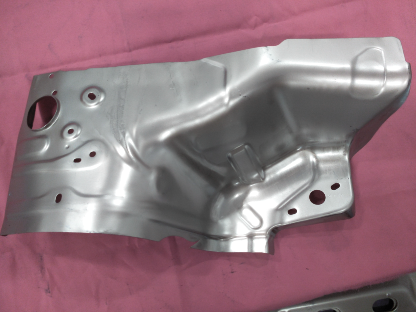

In [3]:
Image.fromarray(processed[1])

## Visual Inspetion with different kernels
Applying different filters to visually inspect and highlight defects in the image. The blurred and gray versions of an image is run through a series kernels (2D matrices) with OpenCV code, which include:

* Sobel-X
* Sobel-Y
* Sharpen
* Laplacian

In [4]:
from skimage.exposure import rescale_intensity
#Convolution function, takes in the image and the kernel for processing, applies the required filters required
def convolve(image, kernel):
    (iH,iW)=image.shape[:2]
    (kH,kW)=kernel.shape[:2]
    pad=(kW-1)/2
    pad=int(pad)
    image=cv.copyMakeBorder(image,pad,pad,pad,pad,cv.BORDER_REPLICATE)
    output=np.zeros((iH,iW),dtype="float32")

    for y in np.arange(pad,iH+pad):
        for x in np.arange(pad,iW+pad):
            roi=image[y-pad:y+pad+1,x-pad:x+pad+1]
            k=(roi*kernel).sum()
            output[y-pad,x-pad]=k
    output=rescale_intensity(output,in_range=(0,255))
    output=(output*255).astype("uint8")
    return output

def run_kerneler(image):
    #Sharpening Kernels
    sharpen=np.array((
    [0,-1,0],
    [-1,5,-1],
    [0,-1,0]),dtype="int")

    #Laplacian Kerner
    laplacian=np.array((
    [0,1,0],
    [1,-4,1],
    [0,1,0]),dtype="int")

    #Sobel Kernel in the X direction, detects the edges only in the X direction
    sobelX=np.array((
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]),dtype="int")

    #Sobel Kernel in the Y direction, detects the edges only in the Y direction
    sobelY=np.array((
    [-1,-2,-1],
    [0,0,0],
    [1,2,1]),dtype="int")

    #Kernel bank, sends the image and the kernel to convolve function, to convolute it
    kernelBank=(
    #("Small Blurring",smallBlur),
    #("Large Blurring",largeBlur),
    ("Sharpen",sharpen),
    ("Sobel X",sobelX),
    ("Sobel Y",sobelY),
    ("Laplacian",laplacian))
    #Adding first image here
    gray, blur, image = pre_processing(image)
    #Converting image to gray-scale here
    #Displaying images here
    #Cycles through all the kernels available in the bank, compares with the image
    for(kernelName,kernel) in kernelBank:
        print("[INFO]Applying {} kernel".format(kernelName))
        convolve_gray_Output=convolve(gray,kernel)
        convolve_blur_Output=convolve(blur,kernel)
        convolve_gray_Output=cv.copyMakeBorder(convolve_gray_Output,0,50,0,0,cv.BORDER_CONSTANT,value=[255,0,0])
        convolve_gray_Output=cv.putText(convolve_gray_Output,"Filter: "+kernelName+" "+"Mode: Gray",(10,(convolve_gray_Output.shape[0]-20)),cv.FONT_HERSHEY_SIMPLEX,0.35, (100,100,100),1,cv.LINE_AA)
        convolve_gray_Output=cv.rectangle(convolve_gray_Output,(0,(convolve_gray_Output.shape[0]-50)),(convolve_gray_Output.shape[1],convolve_gray_Output.shape[0]),(0,0,0),3)
        convolve_blur_Output=cv.copyMakeBorder(convolve_blur_Output,0,50,0,0,cv.BORDER_CONSTANT,value=[255,0,0])
        convolve_blur_Output=cv.putText(convolve_blur_Output,"Filter: "+kernelName+" "+"Mode: Blur",(10,(convolve_blur_Output.shape[0]-20)),cv.FONT_HERSHEY_SIMPLEX,0.35, (100,100,100),1,cv.LINE_AA)
        convolve_blur_Output=cv.rectangle(convolve_blur_Output,(0,(convolve_blur_Output.shape[0]-50)),(convolve_blur_Output.shape[1],convolve_blur_Output.shape[0]),(0,0,0),3)
        cv.imwrite('Results/'+kernelName+"_Gray"+".jpg", convolve_gray_Output)
        cv.imwrite('Results/'+kernelName+"_Blur"+".jpg", convolve_blur_Output) 

In [5]:
run_kerneler("YE358311_Fender_apron\YE358311_Crack_and_Wrinkle_defect\IMG20180905143945.jpg")

[INFO]Applying Sharpen kernel
[INFO]Applying Sobel X kernel
[INFO]Applying Sobel Y kernel
[INFO]Applying Laplacian kernel


<tr>
    <td> <img src="Results/Laplacian_Blur.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Results/Laplacian_Gray.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Results/Sharpen_Blur.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr>
<tr>
    <td> <img src="Results/Sharpen_Gray.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Results/Sobel X_Blur.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Results/Sobel X_Gray.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr>
<tr>
    <td> <img src="Results/Sobel Y_Gray.jpg" alt="Drawing" style="width: 250px;"/> </td>
    <td> <img src="Results/Sobel Y_Blur.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr>

### Deep Learning Approach
The dataset is split into a) training, b) validation & c) test set. Training and test split is 90% and 10% respectively, in the same way training and validation split is 90% and 10% respectively.

In [6]:
import os
import random
train_dir_1 = "YE358311\Train\Defective"
train_dir_2="YE358311\Train\Healthy"
test_dir = "YE358311\Test"
train_defective = ["YE358311\Train\Defective\{}".format(i) for i in os.listdir(train_dir_1)]
train_healthy = ["YE358311\Train\Healthy\{}".format(i) for i in os.listdir(train_dir_2)]
print("Healthy Images in Train Data: {}".format(len(train_healthy)))
print("Defective Images in Train Data: {}".format(len(train_defective)))

Healthy Images in Train Data: 124
Defective Images in Train Data: 101


#### Data labelling for train dataset

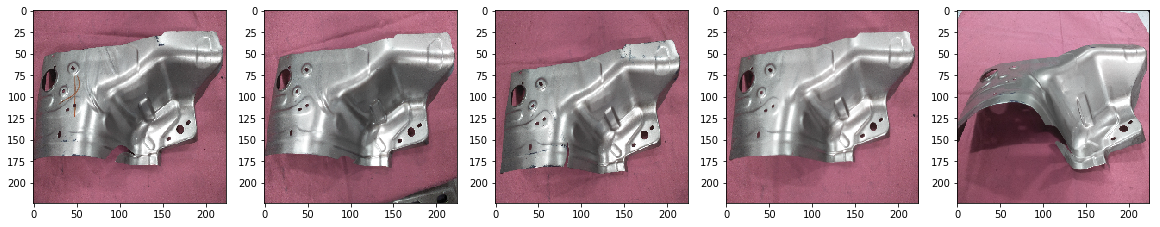

In [7]:
"""X is an array of images
   y is an array of labels 1 & 0
   1 means defect is there
   0 means defect is not there
"""
#adding both type of images to x
y=[]
X=[]
nrows = 224
ncolumns = 224
channels = 3
for image in train_defective:
    X.append(cv.resize(pre_processing(image)[2], (nrows,ncolumns), interpolation=cv.INTER_CUBIC))
    y.append(1)
for image in train_healthy:
    X.append(cv.resize(pre_processing(image)[2], (nrows,ncolumns), interpolation=cv.INTER_CUBIC))
    y.append(0)
plt.figure(figsize=(20,10))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(X[i])

In [8]:
from collections import Counter
print("Unique values: {}".format(Counter(y).keys()))
Counter(y).values()

Unique values: dict_keys([1, 0])


dict_values([101, 124])

In [9]:
#Randomizing both lists in same order
train = list(zip(X, y))
random.shuffle(train)
X, y = zip(*train)
#list to array
X = np.array(X)
y = np.array(y)
print("Shape of train images is {}".format(X.shape))
print("Shape of train labels is {}".format(y.shape))

Shape of train images is (225, 224, 224, 3)
Shape of train labels is (225,)


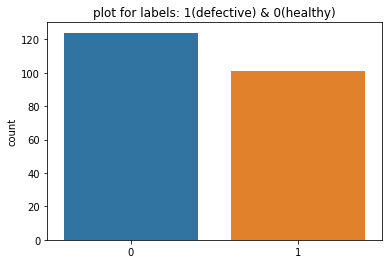

In [10]:
sns.countplot(y)
plt.title("plot for labels: 1(defective) & 0(healthy)");

In [11]:
targets = y
y = np.eye(2)[targets]
y

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.

### Baseline Model
A simple convolutional neural network as the baseline model: 3 Conv2D/MaxPooling2D pairs as the feature extractor and 3 Dense layers as the classifiers. using 20 epochs with early stopping and without data augmentation.

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.callbacks import EarlyStopping

# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
filt_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# build the model
base_model = Sequential()

base_model.add(Conv2D(filt_size, (3, 3), activation='relu', padding='same', input_shape=input_shape)) 
base_model.add(MaxPooling2D(pool_size=(2, 2)))

base_model.add(Conv2D(2*filt_size, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
    
base_model.add(Conv2D(4*filt_size, (3, 3), activation='relu', padding='same'))
base_model.add(MaxPooling2D(pool_size=(2, 2)))
    
base_model.add(Flatten())

base_model.add(Dense(512, activation='relu'))
base_model.add(Dense(512, activation='relu'))

base_model.add(Dense(num_classes, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
# compile the model
base_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
base_model.summary()

Using TensorFlow backend.








Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)     

In [13]:
 # train the model                    
history = base_model.fit(X, y,
                    batch_size=batch_size,
                    epochs=20,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 202 samples, validate on 23 samples
Epoch 1/20
202/202 [==============================] - 344s 2s/step - loss: 7.3062 - acc: 0.5297 - val_loss: 5.6063 - val_acc: 0.6522- ETA: 8:45 - loss: 6.2339 - acc:  - ETA: 1:00 - loss: 6.8063 - acc: 0.556 - ETA: 39s - loss: 7.0118 - acc: 0.5
Epoch 2/20
202/202 [==============================] - 103s 511ms/step - loss: 7.4207 - acc: 0.5396 - val_loss: 5.6063 - val_acc: 0.6522
Epoch 00002: early stopping


#### Data labelling for test dataset

In [45]:
test_defective = ["YE358311\Test\{}.jpg".format(i) for i in range(1,11)]
test_healthy = ["YE358311\Test\{}.jpg".format(i) for i in range(11,26)]
print("Healthy Images in Test Data: {}".format(len(test_healthy)))
print("Defective Images in Test Data: {}".format(len(test_defective)))
X_test=[]
y_test=[]
for image in test_defective:
    X_test.append(cv.resize(pre_processing(image)[2], (nrows,ncolumns), interpolation=cv.INTER_CUBIC))
    y_test.append(1)
for image in test_healthy:
    X_test.append(cv.resize(pre_processing(image)[2], (nrows,ncolumns), interpolation=cv.INTER_CUBIC))
    y_test.append(0)
#Randomizing both lists in same order
test = list(zip(X_test, y_test))
random.shuffle(test)
X_test, y_test = zip(*test)
#list to array
X_test = np.array(X_test)
y_test = np.array(y_test)
print("Shape of test images is {}".format(X_test.shape))
print("Shape of test labels is {}".format(y_test.shape))
targets = y_test
y_test = np.eye(2)[targets]
print("length of Test data: {}".format(len(y_test)))

Healthy Images in Test Data: 15
Defective Images in Test Data: 10
Shape of test images is (25, 224, 224, 3)
Shape of test labels is (25,)
length of Test data: 25


In [15]:
y_test_pred = base_model.predict(X_test)
y_test_pred

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Clearly our data is not suffiecient in itself to train a model from sketch. Baseline model could not recognize the patterns for defect, so next we'll try some pretrained models from tensorflow library.
## Using Transfer Learning
### Inception V3 Model
Inception V3 is a TensorFlow based machine-learning
model, pre-trained on a dataset of images belonging to 1000
classes, with an identification error rate of just 3.4% 

In [24]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# load InceptionV3 from Keras
InceptionV3_model = InceptionV3(include_top=False, input_shape=input_shape)

# add custom Layers
x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
InceptionV3_model = Model(inputs = InceptionV3_model.input, outputs = Custom_Output)
        
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

# compile the model
InceptionV3_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

InceptionV3_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 111, 111, 32) 96          conv2d_98[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, 111, 111, 32) 0           batch_normalization_95[0][0]     
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv2d_123 (Conv2D)             (None, 25, 25, 64)   18432       average_pooling2d_12[0][0]       
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 25, 25, 64)   192         conv2d_117[0][0]                 
__________________________________________________________________________________________________
batch_normalization_116 (BatchN (None, 25, 25, 64)   192         conv2d_119[0][0]                 
__________________________________________________________________________________________________
batch_normalization_119 (BatchN (None, 25, 25, 96)   288         conv2d_122[0][0]                 
__________________________________________________________________________________________________
batch_normalization_120 (BatchN (None, 25, 25, 64)   192         conv2d_123[0][0]                 
__________

conv2d_189 (Conv2D)             (None, 5, 5, 384)    442368      activation_185[0][0]             
__________________________________________________________________________________________________
conv2d_190 (Conv2D)             (None, 5, 5, 384)    442368      activation_185[0][0]             
__________________________________________________________________________________________________
average_pooling2d_18 (AveragePo (None, 5, 5, 2048)   0           mixed9[0][0]                     
__________________________________________________________________________________________________
conv2d_183 (Conv2D)             (None, 5, 5, 320)    655360      mixed9[0][0]                     
__________________________________________________________________________________________________
batch_normalization_182 (BatchN (None, 5, 5, 384)    1152        conv2d_185[0][0]                 
__________________________________________________________________________________________________
batch_norm

In [25]:
# train the model 
history = InceptionV3_model.fit(X, y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Train on 202 samples, validate on 23 samples
Epoch 1/20
202/202 [==============================] - 824s 4s/step - loss: 1.1535 - acc: 0.6040 - val_loss: 8.9464 - val_acc: 0.3043- ETA: 9:37 - loss: 1.1378 - acc: 0.4583 - ETA: 8:20 - loss: 1.2529 - a
Epoch 2/20
202/202 [==============================] - 320s 2s/step - loss: 0.4524 - acc: 0.8366 - val_loss: 0.8275 - val_acc: 0.8696
Epoch 3/20
202/202 [==============================] - 255s 1s/step - loss: 0.3462 - acc: 0.8812 - val_loss: 0.9390 - val_acc: 0.6957
Epoch 00003: early stopping


In [26]:
y_t_pred =InceptionV3_model.predict(X_test)
y_t_pred

array([[7.32528448e-01, 2.67471582e-01],
       [9.99900341e-01, 9.96299277e-05],
       [4.59689766e-01, 5.40310323e-01],
       [9.56445575e-01, 4.35544960e-02],
       [8.34205374e-02, 9.16579485e-01],
       [7.38962144e-02, 9.26103771e-01],
       [1.41841039e-01, 8.58158886e-01],
       [1.03830814e-01, 8.96169186e-01],
       [1.08902603e-01, 8.91097367e-01],
       [9.92248297e-01, 7.75165157e-03],
       [8.35908130e-02, 9.16409194e-01],
       [1.09623931e-01, 8.90376091e-01],
       [5.86298369e-02, 9.41370189e-01],
       [1.34299742e-02, 9.86570060e-01],
       [5.23703881e-02, 9.47629631e-01],
       [1.62620675e-02, 9.83737946e-01],
       [1.22962981e-01, 8.77036989e-01],
       [2.18496639e-02, 9.78150368e-01],
       [1.93542644e-01, 8.06457341e-01],
       [7.75156729e-03, 9.92248416e-01],
       [1.00117847e-01, 8.99882197e-01],
       [8.76569867e-01, 1.23430103e-01],
       [8.70177150e-01, 1.29822820e-01],
       [1.16809718e-01, 8.83190215e-01],
       [9.992511

The pre-trained model tries to
probabilistically determine which category (defective and non-defective) a particular machine part falls into.
If the probability assigned to either category  exceeds 0.5, then the machine part is
classified into that particular category.

In [54]:
def make_classes(y_pred):
    for i in y_pred:
        if i[0] > 0.5:
            i[0]=1
            i[1]=0
        elif i[0] <= 0.5:
            i[1]=1
            i[0]=0
    return y_pred
make_classes(y_t_pred)

In [56]:
def compare(y_test,y_t_pred):
    Y_Predictions = pd.DataFrame([i[0] for i in y_t_pred],copy=False)
    y_Test = pd.DataFrame([i[0] for i in y_test],copy=False)
    df_dnn = pd.concat([Y_Predictions,y_Test],axis=1)
    df_dnn.columns=['Y_Predictions','y_Test']
    return df_dnn
df_dnn = compare(y_test,y_t_pred)

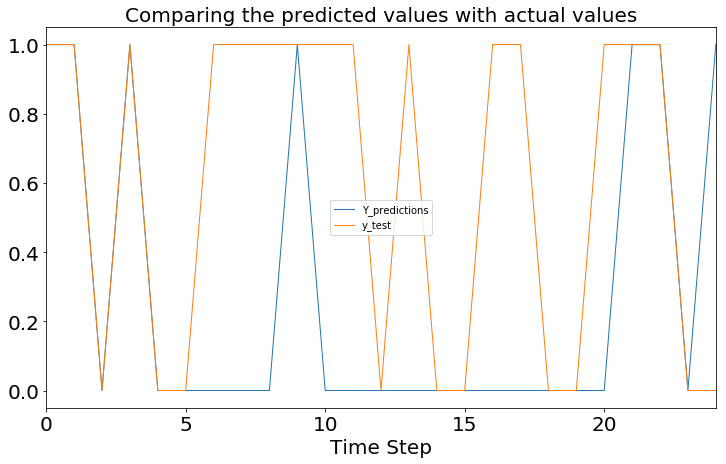

In [34]:
df_dnn.plot(figsize=(12,7), linewidth=1, fontsize=20)
plt.xlabel('Time Step', fontsize=20);
plt.title("Comparing the predicted values with actual values", fontsize=20);

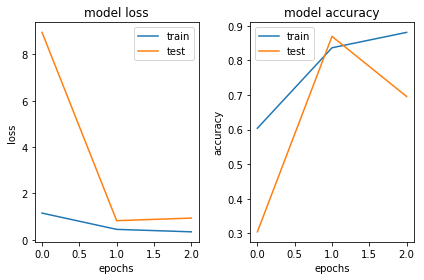

In [42]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend();
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout();

In [48]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
testy = y_test[:, 0]
yt_classes = y_t_pred[:, 0]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yt_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yt_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yt_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yt_classes)
print('F1 score: %f' % f1)

Accuracy: 0.440000
Precision: 0.571429
Recall: 0.266667
F1 score: 0.363636


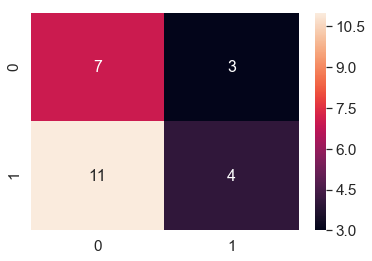

In [49]:
# confusion matrix
matrix = confusion_matrix(testy, yt_classes)      
df_cm = pd.DataFrame(matrix, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16});# font size

This model is performing poorely due to some issues which are discussed [here](http://blog.datumbox.com/the-batch-normalization-layer-of-keras-is-broken/)

### MobileNet
Using Keras Application MobileNet fine-tuning the classifier by using 1 GlobalAveragePooling2D layer and 2 Dense layers

In [52]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

# parameters for architecture
input_shape = (224, 224, 3)
num_classes = 2
conv_size = 32

# parameters for training
batch_size = 16
num_epochs = 20

# load MobileNet from Keras
MobileNet_model = MobileNet(include_top=False, input_shape=input_shape)

# add custom Layers
x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)
Custom_Output = Dense(num_classes, activation='softmax')(x)

# define the input and output of the model
MobileNet_model = Model(inputs = MobileNet_model.input, outputs = Custom_Output)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)   
# compile the model
MobileNet_model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])

MobileNet_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128 

In [53]:
# train the model 
history = MobileNet_model.fit(X, y,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[es])

Train on 202 samples, validate on 23 samples
Epoch 1/20
202/202 [==============================] - 479s 2s/step - loss: 0.9232 - acc: 0.7525 - val_loss: 0.6617 - val_acc: 0.8696 - ETA: 7:01 - loss: 0.8463 - acc: 0.687 - ETA: 7:52 - loss: 0.7373 - ac
Epoch 2/20
202/202 [==============================] - 211s 1s/step - loss: 0.2762 - acc: 0.9109 - val_loss: 0.4114 - val_acc: 0.9130
Epoch 3/20
202/202 [==============================] - 202s 1s/step - loss: 0.0699 - acc: 0.9752 - val_loss: 0.0959 - val_acc: 0.9565
Epoch 4/20
202/202 [==============================] - 211s 1s/step - loss: 0.0708 - acc: 0.9851 - val_loss: 0.0480 - val_acc: 0.9565
Epoch 5/20
202/202 [==============================] - 235s 1s/step - loss: 0.0293 - acc: 0.9901 - val_loss: 0.5408 - val_acc: 0.8696
Epoch 6/20
202/202 [==============================] - 200s 989ms/step - loss: 0.1135 - acc: 0.9752 - val_loss: 0.2319 - val_acc: 0.9565
Epoch 00006: early stopping


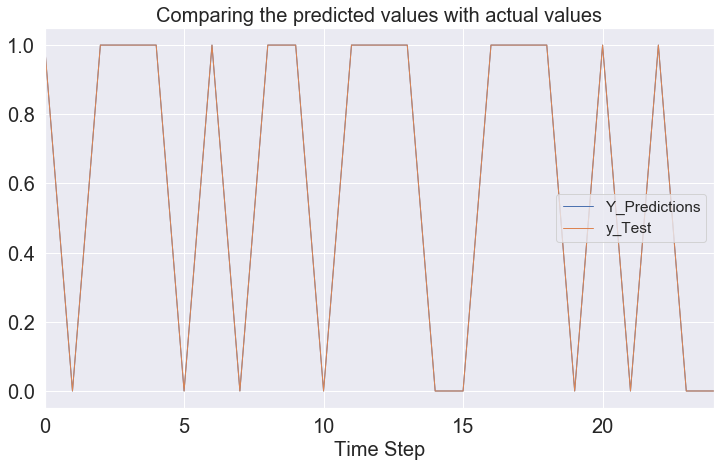

In [58]:
y_t_pred =MobileNet_model.predict(X_test)
y_t_pred = make_classes(y_t_pred)
df_dnn = compare(y_test,y_t_pred)
df_dnn.plot(figsize=(12,7), linewidth=1, fontsize=20)
plt.xlabel('Time Step', fontsize=20);
plt.title("Comparing the predicted values with actual values", fontsize=20);

In [59]:
testy = y_test[:, 0]
yt_classes = y_t_pred[:, 0]
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yt_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yt_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yt_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yt_classes)
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


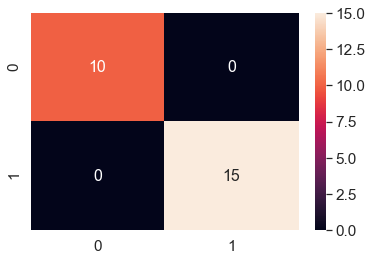

In [60]:
# confusion matrix
matrix = confusion_matrix(testy, yt_classes)      
df_cm = pd.DataFrame(matrix, range(2),
                  range(2))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16});# font size

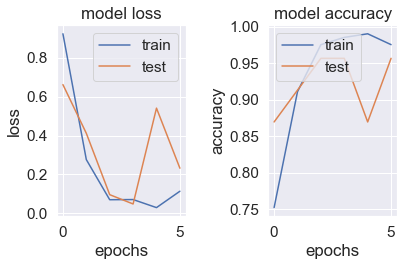

In [61]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend();
plt.subplot(1, 2, 2)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.tight_layout();

In [62]:
#saving the model 
MobileNet_model.save_weights('MobileNet_model_wieghts.h5')
MobileNet_model.save('MobileNet_model_keras.h5')